# Code zu Versuch C: Akustisch-optischer-Effekt

#### Der folgende Code wird für die Auswertung des dritten Versuches verwendet

In [41]:
# Importing necessary libraries
#import pandas as pd
import numpy as np
import scipy as sc
from scipy import constants
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

 # für numerisches Lösen von Gleichung
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
import scipy.optimize as opt

# Fehlerfortpflanzung in Python
from uncertainties import ufloat
import uncertainties.umath as um
from uncertainties import unumpy, wrap # für Funktionen

plt.rcParams['text.usetex'] = True #LaTeX

# Aufgabe 1: Bestimmung des Bragg-Winkels

#### Der Bragg-Winkel berechnet sich mithilfe der Formel: $n \lambda = 2 d sin(\theta_i)$

#### In unserem Fall wurde für die Berechnung des Bragg-Winkels zwischen der nullten und ersten Ordnung der folgende Zusammenhang verwendet: $\theta_B=\frac{s}{2d}$, wobei s die Distanz zwischen dem nullten und ersten Maxima ist und d die gesamt Distanz.

In [42]:
# Distances
d1 = 0.080
d2 = 0.150
d3 = 1.370
error_d1 = 0.003
error_d2 = 0.003
error_d3 = 0.005

# Gesamtdistanz
d_ges = d1 + d2 + d3

# Fehlergesamtdistanz
d_ges_error = np.sqrt(error_d1**2 + error_d2**2 + error_d3**2)

# Distanz erste und nullte Ordnung
s = 0.020
error_s = 0.001

# Berechnung des optimalen Bragg-Winkels
theta_bragg = np.arctan(s / (2*d_ges))
#theta_bragg = s / (2*d_ges)

error_theta_bragg = np.sqrt((error_s / (2*d_ges + s**2 / (2 * d_ges)))**2 + (-s * d_ges_error / (2*d_ges**2 + s**2))**2)
#error_theta_bragg = np.sqrt((error_s / (2 * d_ges))**2 + (- s /(2 * d_ges**2) * d_ges_error)**2)

print(f'Der Bragg Winkel ist {theta_bragg * 1000}mrad mit einer Unsicherheit von {error_theta_bragg*1000}')



Der Bragg Winkel ist 6.249918621698962mrad mit einer Unsicherheit von 0.31353571801980007


#### Die hohe Unsicherheit erhielten wir aufgrund der Gaußschen Fehlerfortpflanzung, die Messung wurde mit einem Maßband durchgeführt was zu relativ hohen Fehlern durch das ablesen führte

## Umrechnungsfunktion -> Daten stammen aus der gegebenen Tabelle

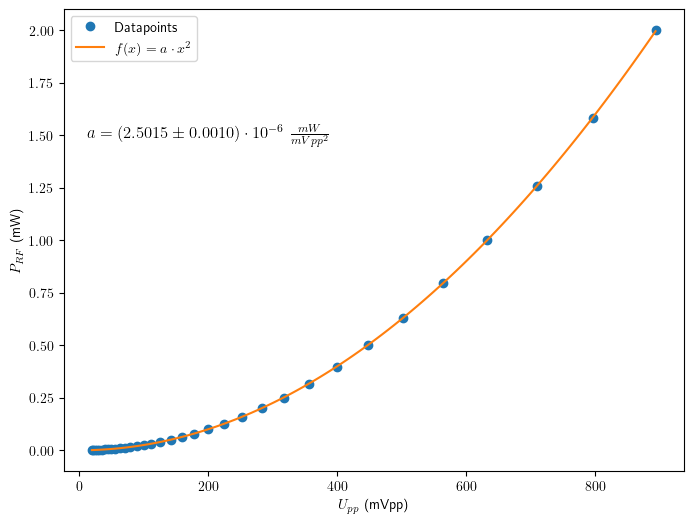

2.5014572479523087e-06


In [43]:
mVpp = np.array([
    20.0, 22.4, 25.2, 28.3, 31.7, 35.6, 39.9, 44.8, 50.2, 56.4, 63.2, 71.0, 79.6, 
    89.3, 100, 112, 126, 142, 159, 178, 200, 224, 252, 283, 317, 356, 399, 448, 
    502, 564, 632, 710, 796, 893
])

mW = np.array([
    0.0010, 0.0013, 0.0016, 0.0020, 0.0025, 0.0032, 0.0040, 0.0050, 0.0063, 0.0079, 
    0.0100, 0.0126, 0.0158, 0.0200, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794, 
    0.100, 0.126, 0.158, 0.200, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794, 
    1.00, 1.26, 1.58, 2.00
])

# fit funktion
def fit_function(x, a):
    return a * x**2

#curve fit durchführen
params, covariance = curve_fit(fit_function, mVpp, mW)

#unsicherheit der curve fit function
a_uncertainty = np.sqrt(np.diag(covariance))[0]

#Fit kurve berechnen
mVpp_fit = np.linspace(min(mVpp), max(mVpp), 100)
mW_fit = fit_function(mVpp_fit, *params)

# text im plot ausgeben
#fit_text = f'$a = {params[0] * 1e6:.4f} \\cdot 10^{{-6}} \\; \\frac{{mW}}{{mVpp^2}}$'
fit_text = f'$a = ({params[0] * 1e6:.4f} \\pm {a_uncertainty * 1e6:.4f}) \\cdot 10^{{-6}} \\; \\frac{{mW}}{{mVpp^2}}$'

# erstellen eines plots 
plt.figure(figsize=(8, 6))
plt.plot(mVpp, mW, 'o', label='Datapoints')
plt.plot(mVpp_fit, mW_fit, '-', label='$f(x) = a \\cdot x^2$')
plt.xlabel('$U_{pp}$ (mVpp)')
plt.ylabel('$P_{RF}$ (mW)')
plt.text(200, 1.5, fit_text, fontsize=12, ha='center', va='center')
#plt.title('mVpp vs. mW Plot')
plt.legend()
plt.grid(False)
plt.show()

a = params[0]
print(a)

# Aufgabe 2: Insertion loss

### Der Insertion Loss wurde mithilfe der folgenden Formel berechnet, dabei wurde keine RF angelegt: $IL = 1 - P_{out} / P_{in}$

In [44]:
P_in = 0.826 #mW
error_P_in = 0.002 #mW

P_out = 0.758 #mW
error_P_out = 0.002 #mW

IL = 1 - (P_out / P_in)
error_IL = np.sqrt((- error_P_out / P_in)**2 + (P_out * error_P_in / (P_in**2))**2)

print(f'Der Insertion Loss ist {IL}mW mit einer Unsicherheit von {error_IL}')

Der Insertion Loss ist 0.08232445520581111mW mit einer Unsicherheit von 0.003286320364550359


### Nun wollen wir $P_{sat}$ bestimmen, dafür wird zunächst $\epsilon = P_1 / P_{out}$ bestimmt und gegen $P_{RF}$ aufgetragen, mithilfe des Fits kann man dan $P_{sat}$ bestimmen.

In [45]:
P_1 = np.array([0, 18.5, 43.7, 80.6, 135, 196, 261, 334, 407, 477, 541, 600, 650, 691, 719, 736, 737, 730, 713, 685, 652, 632]) #mikroWatt
error_P_1 = np.array([0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]) 

P_0 = np.array([804, 794, 769, 728, 678, 618, 550, 473, 400, 326, 257, 197, 144, 102.0, 71.7, 52.0, 43.0, 45.3, 56.5, 75.7, 102.0, 134.0]) #microWatt
error_P_0 = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]) 

P_out_2 = P_0 + P_1
P_out_error_2 = np.sqrt((P_1 * error_P_0)**2 + (P_0 * error_P_1)**2)

epsilon = P_1 / P_out_2
error_epsilon = np.sqrt((error_P_1 / P_out_2)**2 + (-P_1 * P_out_error_2 / (P_out_2**2))**2)

print(f'Die Werte für epsilon lauten für den ersten Datenwert {epsilon}')
print(f'Die Unsicherheit für epsilon beträgt: {error_epsilon}')

Die Werte für epsilon lauten für den ersten Datenwert [0.         0.02276923 0.05377138 0.09967846 0.16605166 0.24078624
 0.32182491 0.41387856 0.50433705 0.59402242 0.67794486 0.75282309
 0.8186398  0.87137453 0.90932085 0.93401015 0.94487179 0.941571
 0.9265757  0.90048639 0.86472149 0.82506527]
Die Unsicherheit für epsilon beträgt: [0.         0.00445817 0.01019539 0.01805989 0.02824046 0.03835717
 0.04831694 0.05939368 0.07132714 0.0854802  0.10176692 0.11930209
 0.13728421 0.15350446 0.16619331 0.1749101  0.17886038 0.17765245
 0.17224697 0.16316265 0.15136785 0.13917336]


#### Nun plotten wir $\epsilon$ gegen gegen $P_{RF}$ um daraus anschließend mithilfe des Fitts $P_{sat}$ zu bestimmen

##### Nun rechnen wir die $U_{pp}$ in $P_{RF}$ um

In [46]:
U_pp = np.array([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630])
P_RF = a * U_pp**2
print(P_RF)

[0.         0.00225131 0.00900525 0.0202618  0.03602098 0.05628279
 0.08104721 0.11031426 0.14408394 0.18235623 0.22513115 0.27240869
 0.32418886 0.38047165 0.44125706 0.50654509 0.57633575 0.65062903
 0.72942493 0.81272346 0.90052461 0.99282838]


/var/folders/7g/074dyn7d5zqchxk1vd2rgmzr0000gn/T/ipykernel_1617/3017491147.py:3: RuntimeWarning: invalid value encountered in sqrt
  return a * np.sin(np.pi / 2 * np.sqrt(P_RF / P_sat))**2


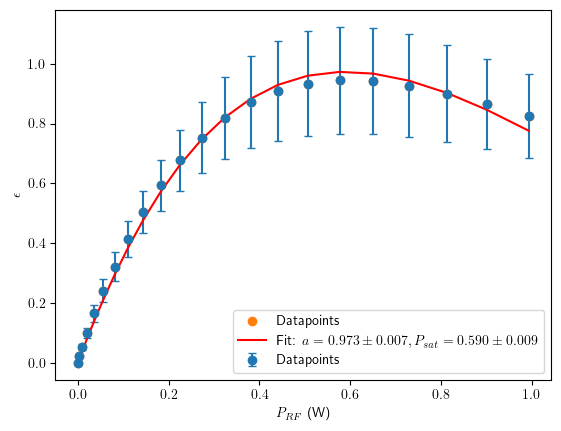

Berechneter Wert für a: 0.973 ± 0.007
Berechneter Wert für P_sat: 0.590 ± 0.009


In [47]:
#def fit function
def fit_epsilon(P_RF, a, P_sat):
    return a * np.sin(np.pi / 2 * np.sqrt(P_RF / P_sat))**2

# Curve fitting mit der Funktion fit_function
params, covariance = curve_fit(fit_epsilon, P_RF, epsilon, p0=[0.915, 1.21])


a_fit, P_sat_fit = params
errors = np.sqrt(np.diag(covariance))

a_err, P_sat_err = errors

#erstellen eines plots 
#plt.figure(figsize=(8, 6))
plt.errorbar(P_RF, epsilon, yerr=error_epsilon, fmt='o', label='Datapoints', capsize=3)
plt.plot(P_RF, epsilon, 'o', label='Datapoints')
plt.plot(P_RF, fit_epsilon(P_RF, *params), label=f'Fit: $a = {a_fit:.3f} \pm {a_err:.3f}, P_{{sat}} = {P_sat_fit:.3f} \pm {P_sat_err:.3f}$', color='red')
plt.xlabel('$P_{RF}$ (W)')
plt.ylabel('$\epsilon$')
plt.legend()
plt.grid(False)
plt.show()

print(f'Berechneter Wert für a: {a_fit:.3f} ± {a_err:.3f}')
print(f'Berechneter Wert für P_sat: {P_sat_fit:.3f} ± {P_sat_err:.3f}')


# Aufgabe 3: Frequenzabhängigkeit und Qualitätsfaktor

### In der folgenden Aufgabe wurde die RF-Leistung konstant bei 500mW gehalten, nun wurde die RF-Frequenz um Designwert in Intervall zw. 60 und 100 MHz

### Daten der Frequenz und Messung Abstaand

In [48]:
f_RF = np.array([60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102])
D = np.array([0.0155, 0.015, 0.0155, 0.0165, 0.017, 0.019, 0.019, 0.020, 0.0205, 0.021, 0.022, 0.023, 0.024, 0.0245, 0.025])
D_error = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
I_0 = np.array([377, 315, 281, 238, 222, 219, 220, 229, 243, 270, 317, 377, 443, 511, 581])
I_0_error = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
I_1 = np.array([394, 450, 517, 528, 549, 566, 570, 570, 558, 536, 505, 452, 388, 319, 248])
I_1_error = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Im folgenden berechne ich die Werte die für den Fit notwendig sind

In [49]:
epsilon_3 = I_1 / (I_0 + I_1)
error_epsilon_3 = np.sqrt((I_0 * I_1_error / ((I_0 + I_1)**2))**2 + (-I_1 * I_0_error / ((I_0 + I_1)**2))**2)

## Bestimmung Qualitätsfaktor aus $f_{RF}$ und aus $\epsilon$

#### Erstellen des Plots

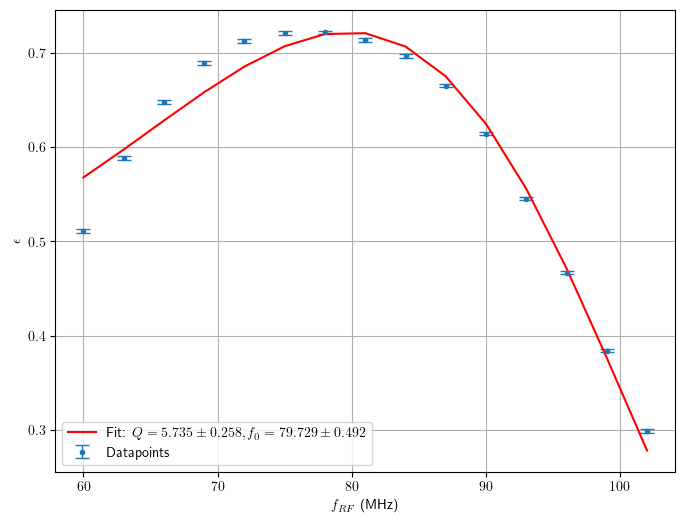

Berechneter Wert für a: 0.722 ± 0.009
Berechneter Wert für Q: 5.735 ± 0.258
Berechneter Wert für f_0: 79.729 ± 0.492


In [50]:
#fit funktion
def fit_epsilon_3(f, a, Q, f_0):
    x = (Q / 4) * (f / f_0) * (1 - f / f_0)
    return a * np.sinc(x)**2

# Curve fitting mit der Funktion fit_epsilon
params, covariance = curve_fit(fit_epsilon_3, f_RF, epsilon_3 , p0=[0.5, 5, 70]) 

a_fit, Q_fit, f_0_fit = params  # Angepasste Parameter
errors = np.sqrt(np.diag(covariance))  # Fehler der Parameter
a_err, Q_err, f_0_err = errors 

#fit_epsilon_3 = np.linspace(min(f_RF), max(f_RF), 500)  # Erzeugt 500 Werte zwischen min(f_RF) und max(f_RF)
#plt.plot(f_fit, fit_epsilon_3(f_fit, *params), label='Fit', color='red')

#erstellen eines plots 
plt.figure(figsize=(8, 6))
plt.errorbar(f_RF, epsilon_3, yerr=error_epsilon_3, fmt='o', markersize=3, label='Datapoints', capsize=5, capthick=1, elinewidth=1)
#plt.plot(f_RF, epsilon_3, 'o', label='Datapoints')
plt.plot(f_RF, fit_epsilon_3(f_RF, *params), label=f'Fit: $Q = {Q_fit:.3f} \pm {Q_err:.3f}, f_0 = {f_0_fit:.3f} \pm {f_0_err:.3f}$', color='red')
plt.xlabel('$f_{RF}$ (MHz)')
plt.ylabel('$\epsilon$')
plt.legend()
plt.grid(True)
plt.show()

print(f'Berechneter Wert für a: {a_fit:.3f} ± {a_err:.3f}')
print(f'Berechneter Wert für Q: {Q_fit:.3f} ± {Q_err:.3f}')
print(f'Berechneter Wert für f_0: {f_0_fit:.3f} ± {f_0_err:.3f}')

## Untersuchen des Bragg-Winkels abhängig von der RF-Frequenz

#### Daten

In [51]:
theta_b_3 = np.arctan(D / (2*d_ges)) * 1000 #mrad

#berechnung des fehlers
prefactor = 1 / (1 + (D / (2 * d_ges))**2)
df_dD = prefactor * (1 / (2 * d_ges))
df_ddges = prefactor * (-D / (2 * d_ges**2))
error_theta_b_3 = np.sqrt((df_dD * D_error)**2 + (df_ddges * d_ges_error)**2) #mrad

print(theta_b_3)
print(error_theta_b_3)


[4.84371212 4.68746567 4.84371212 5.1562043  5.31245002 5.93743023
 5.93743023 6.24991862 6.40616236 6.56240579 6.87489169 7.18737623
 7.49985938 7.65610041 7.81234106]
[0.03124927 0.03124932 0.03124927 0.03124918 0.03124913 0.03124891
 0.03124891 0.03124879 0.03124873 0.03124867 0.03124854 0.0312484
 0.03124826 0.03124818 0.03124811]


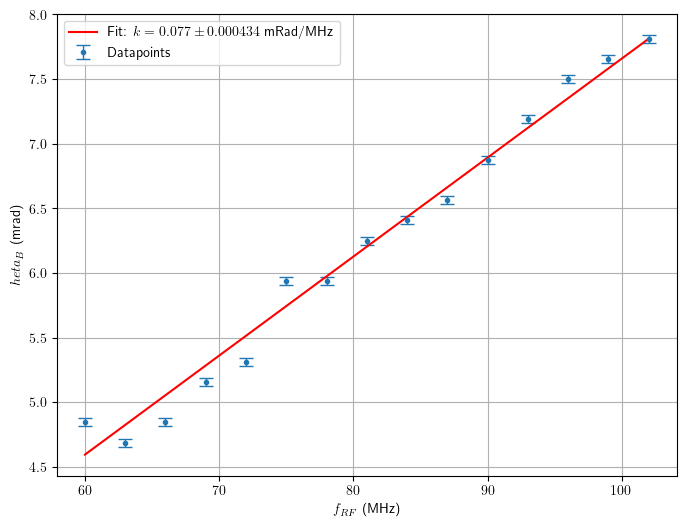

In [52]:
#fit funktion
def fit_theta_B(k, x):
    return k * x

# Curve fitting mit der Funktion fit_epsilon
params, covariance = curve_fit(fit_theta_B, f_RF, theta_b_3 ) 

k_fit = params[0]  # Angepasste Parameter
errors = np.sqrt(np.diag(covariance))  # Fehler der Parameter
k_err = errors[0] 

plt.figure(figsize=(8, 6))
plt.errorbar(f_RF, theta_b_3, yerr=error_theta_b_3, fmt='o', markersize=3, label='Datapoints', capsize=5, capthick=1, elinewidth=1)
plt.plot(f_RF, fit_theta_B(f_RF, *params), label=f'Fit: $k = {k_fit:.3f} \pm {k_err:.6f}$ mRad/MHz', color='red')
plt.xlabel('$f_{RF}$ (MHz)')
plt.ylabel('$\theta_{B}$ (mrad)')
plt.legend()
plt.grid(True)
plt.show()

# Aufgabe 4: Messung der Winkelabhängigkeit und Vergleich des Qualitätsfaktors

#### Daten

In [53]:
ticks = np.array([27, 24, 21, 18, 15, 12, 9, 6, 3, 0, -3, -6, -9, -12, -15, -18, -21, -24, -27])
# the ticks do not have an error

degrees = ticks / 27

I_0_4 = np.array([810, 810, 801, 776, 737, 761, 701, 554, 230, 225, 424, 681, 779, 596, 323, 253, 467, 742, 763])
I_0_4_error = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

I_1_4 = np.array([16.6, 14.8, 11.8, 28.4, 59.0, 20.4, 78.5, 339, 566, 566, 374, 85.1, 25.4, 54.7, 25.0, 13.1, 13.4, 17.2, 10.7])
I_1_4_error = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 2, 2, 2, 2, 
                  0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])


#### Notwendige Berechnungen durchführen

In [54]:
theta_bragg_4 = theta_bragg * (180 / (np.pi * 1000))

delta = degrees - theta_bragg_4

delta_big = delta * 0.001 / theta_bragg_4
delta_big_error = 0.01796

print(delta_big)

epsilon_4 =  I_1_4 / (I_0_4 + I_1_4)
error_epsilon_4 = np.sqrt((I_0_4 * I_1_4_error / ((I_0_4 + I_1_4)**2))**2 + (-I_1_4 * I_0_4_error / ((I_0_4 + I_1_4)**2))**2)

[ 2.79156316e+00  2.48127837e+00  2.17099357e+00  1.86070878e+00
  1.55042398e+00  1.24013918e+00  9.29854388e-01  6.19569592e-01
  3.09284796e-01 -1.00000000e-03 -3.11284796e-01 -6.21569592e-01
 -9.31854388e-01 -1.24213918e+00 -1.55242398e+00 -1.86270878e+00
 -2.17299357e+00 -2.48327837e+00 -2.79356316e+00]


#### Plot

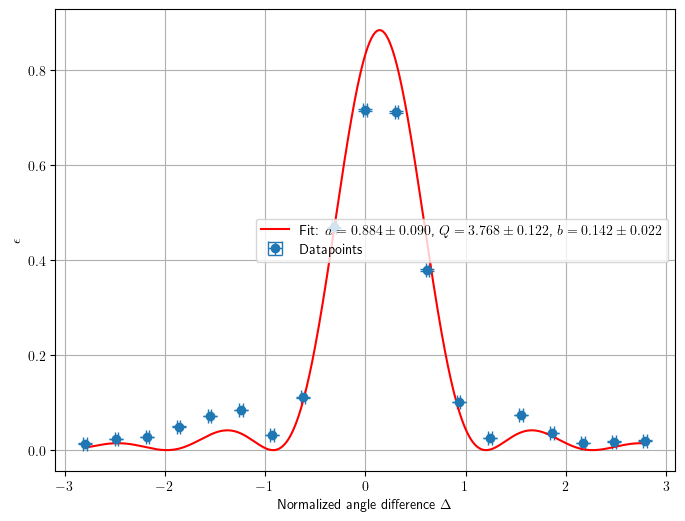

In [55]:
# Definiere die Fit-Funktion
def epsilon_fit_4(delta, a, Q, b):
    return a * np.sinc((Q / 4) * (delta - b))**2

# Fitte die Funktion an die Daten
params, covariance = curve_fit(epsilon_fit_4, delta_big, epsilon_4, sigma=error_epsilon_4, p0=[0.8, 5.0, 0.8])
a_fit, Q_fit, b_fit = params
errors = np.sqrt(np.diag(covariance))
a_err, Q_err, b_err = errors

# Fit-Kurve generieren
delta_fit = np.linspace(min(delta_big), max(delta_big), 600)
epsilon_fit_values = epsilon_fit_4(delta_fit, *params)

plt.figure(figsize=(8, 6))
plt.errorbar(delta_big, epsilon_4,xerr=delta_big_error, yerr=error_epsilon_4, fmt='o', linestyle='none', label='Datapoints', capsize=5, capthick=1, elinewidth=1)

plt.plot(delta_fit, epsilon_fit_values, label=f'Fit: $a = {a_fit:.3f} \pm {a_err:.3f}$, $Q = {Q_fit:.3f} \pm {Q_err:.3f}$, $b = {b_fit:.3f} \pm {b_err:.3f}$', color='red')
#delta_fit = np.linspace(min(delta_big), max(delta_big), 300)
#plt.plot(delta_fit, epsilon_fit(delta_fit, *params), label=f'Fit: $a = {a_fit:.3f} \pm {a_err:.3f}$, $Q = {Q_fit:.3f} \pm {Q_err:.3f}$, $b = {b_fit:.3f} \pm {b_err:.3f}$', color='red')
plt.xlabel('Normalized angle difference $\Delta$')
plt.ylabel('$\epsilon$')
plt.legend()
plt.grid(True)
plt.show()

# Aufgabe 5: Messung der Winkelabhängigkeit der maximalen Beugungseffizienz 

### In diesem Experiment wird nun die RF Frequenz von 60 MHz auf 100 MHz variiert, der Bragg Winkel wird immer adjustiert um die maximalen Effizienz zu erzielen, somit sieht man wie die maximalen Effezienz sich verhält abhängig von der RF-Frequenz

#### Daten

In [56]:
f_RF_5 = np.array([60, 65, 70, 75, 80, 85, 90, 95, 100])
I_1_5 = np.array([427, 515, 559, 579, 590, 585, 559, 509, 440])
I_1_5_error = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Plot

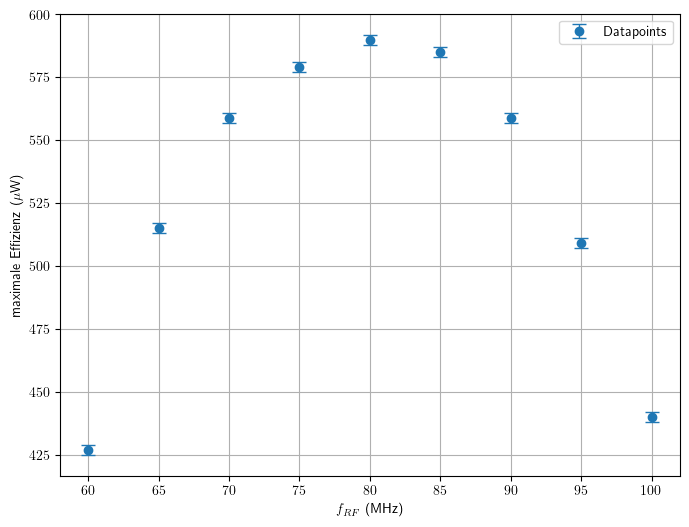

In [57]:
plt.figure(figsize=(8, 6))
plt.errorbar(f_RF_5, I_1_5,yerr=I_1_5_error, fmt='o', linestyle='none', label='Datapoints', capsize=5, capthick=1, elinewidth=1)

#plt.plot(delta_fit, epsilon_fit_values, label=f'Fit: $a = {a_fit:.3f} \pm {a_err:.3f}$, $Q = {Q_fit:.3f} \pm {Q_err:.3f}$, $b = {b_fit:.3f} \pm {b_err:.3f}$', color='red')
#delta_fit = np.linspace(min(delta_big), max(delta_big), 300)
#plt.plot(delta_fit, epsilon_fit(delta_fit, *params), label=f'Fit: $a = {a_fit:.3f} \pm {a_err:.3f}$, $Q = {Q_fit:.3f} \pm {Q_err:.3f}$, $b = {b_fit:.3f} \pm {b_err:.3f}$', color='red')
plt.xlabel('$f_{RF}$ (MHz)')
plt.ylabel('maximale Effizienz ($\mu$W)')
plt.legend()
plt.grid(True)
plt.show()